# Funcionamiento de LIME

Como hemos comentado, LIME emplea una aproximación basada en modelos interpretables locales. La idea clave es generar un conjunto de datos perturbado alrededor de la instancia de interés y observar cómo nuestro modelo complejo que no sabemos interpretar realiza predicciones en estas nuevas instancias. Luego, se entrena un modelo interpretable, como una regresión logística, en el conjunto de datos perturbado para capturar la relación entre las características y las predicciones del modelo complejo.

Supongamos que tenemos un modelo complejo $f$ que toma una entrada $x$ y devuelve una predicción $f(x)$. El objetivo de LIME es aproximar el comportamiento de $f$ en una región local alrededor de un punto de datos específico $x_0$. A continuación se describe el proceso de LIME de manera simplificada:

1. Elegimos un punto de datos de interés $x_0$ que queremos explicar.
2. Creamos un conjunto de muestras perturbadas alrededor de $x_0$. Estas perturbaciones pueden ser generadas mediante técnicas como el muestreo aleatorio. Denotemos estas muestras como $X'={x_1',x_2',\cdots,x_n'}$.
3. Calculamos las predicciones del modelo $f$ en las muestras perturbadas: $F'={f(x_1'),f(x_2'),\cdots,f(x_n')}$.
4. Asignamos pesos a las muestras perturbadas en función de cuán similares son a $x_0$. Esto se puede hacer utilizando una función de similitud, como la distancia euclidiana. Los pesos se representan como $W={w_1,w_2,\cdots,w_n}$.
5. Utilizamos las muestras perturbadas y sus pesos para ajustar un modelo explicativo local, por ejemplo, un modelo lineal, que aproxima el comportamiento de $f$ en la vecindad de $x_0$. Denotemos este modelo como $g(x)$.
6. Utilizamos el modelo local $g$ para explicar el comportamiento de $f$ en $x_0$. Esto puede implicar la identificación de las características más importantes y cómo contribuyen a la predicción en $x_0$.

# Implementación

Importar librerias.

In [26]:
import lime
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier  # Importar la clase MLPClassifier para la red neuronal
from sklearn.preprocessing import StandardScaler

Leer datos de los iris de las flores y mostrarlos. Usamos una simplificación de los datos a solo dos variables independientes o características para poder representarlo en el plano.

Text(0.5, 1.0, 'Diagrama de dispersión de datos')

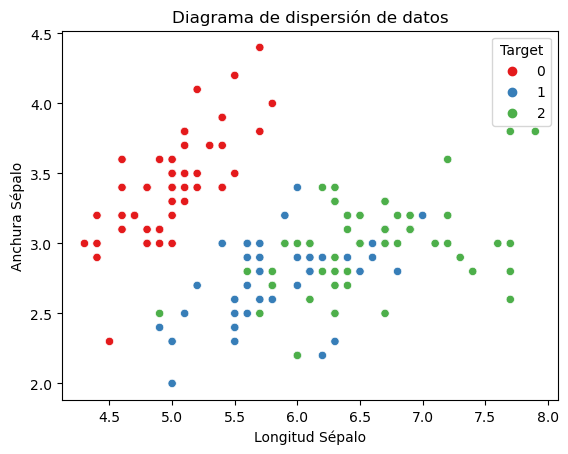

In [27]:
# Cargar el conjunto de datos de Iris como ejemplo
iris = load_iris()
X = iris.data[:, :2]  # Uso solo las dos primeras características para que sea fácil de ver (sepal length y sepal width)
y = iris.target

# Crear un DataFrame para mostrar los datos
data_df = pd.DataFrame(data=X, columns=['Longitud Sépalo', 'Anchura Sépalo'])
data_df['Target'] = y

# Representación gráfica de los datos
sns.scatterplot(x='Longitud Sépalo', y='Anchura Sépalo', hue='Target', data=data_df, palette="Set1")
plt.xlabel('Longitud Sépalo')
plt.ylabel('Anchura Sépalo')
plt.title('Diagrama de dispersión de datos')

Entrenamos un modelo complejo no interpretable, en este caso una red neuronal.

In [28]:
# Modelo complejo (por ejemplo una red neuronal)
complex_model = MLPClassifier(hidden_layer_sizes=(50, 20), max_iter=5000)
complex_model.fit(X, y)


MLPClassifier(hidden_layer_sizes=(50, 20), max_iter=5000)

## Elegir un punto de interés

Escogemos una instancia de los datos para representar el funcionamiento de LIME y lo mostramos con el resto de datos. En particular se ha escogido una muestra donde hay bastante confusión.

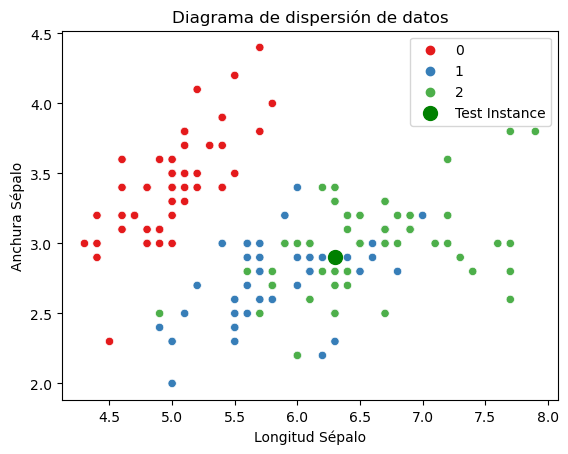

In [32]:
# Seleccionar una instancia de prueba
instance_idx = 103
instance = X[instance_idx]

sns.scatterplot(x='Longitud Sépalo', y='Anchura Sépalo', hue='Target', data=data_df, palette="Set1")
plt.xlabel('Longitud Sépalo')
plt.ylabel('Anchura Sépalo')
plt.title('Diagrama de dispersión de datos')
# Mostrar la instancia de prueba en el gráfico
plt.scatter(instance[0], instance[1], color='green', marker='o', s=100, label='Test Instance')
plt.legend()
plt.show()

## Generación de muestras perturbadas

A continuación, antes de ajustar un modelo interpretable más simple (en nuestro caso Regresión Logística), generamos perturbaciones alrededor de la instancia donde estamos trabajando de manera local. Este proceso por el cual estamos generando un remuestreo de nuestros datos se conoce como *Bootstrap*. Estos puntos se representan en negro para reflejar que no están clasificados.

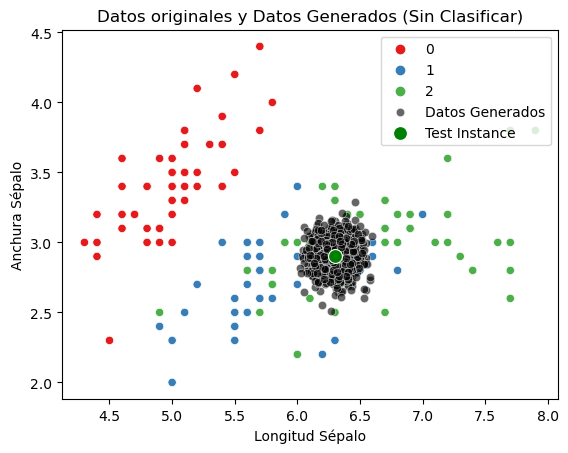

In [33]:
# Instancia de prueba seleccionada
test_instance = X[instance_idx]

# Crear perturbaciones alrededor de la instancia seleccionada
num_perturbations = 1000
perturbed_data = []
for _ in range(num_perturbations):
    perturbation = np.random.normal(0, 0.1, size=test_instance.shape)
    perturbed_instance = test_instance + perturbation
    perturbed_data.append(perturbed_instance)

# Gráfica de los datos originales con sus clasificaciones
sns.scatterplot(x='Longitud Sépalo', y='Anchura Sépalo', hue='Target', data=data_df, palette="Set1")

# Gráfica de los puntos generados por bootstrap en negro
perturbed_data = np.array(perturbed_data)
sns.scatterplot(x=perturbed_data[:, 0], y=perturbed_data[:, 1], marker='o', color='black', alpha=0.6, label='Datos Generados')
sns.scatterplot(x=[test_instance[0]], y=[test_instance[1]], marker='o', color='green', s=100, label='Test Instance')
plt.xlabel('Longitud Sépalo')
plt.ylabel('Anchura Sépalo')
plt.title('Datos originales y Datos Generados (Sin Clasificar)')
plt.legend()
plt.show()

## Predicción de las muestras

complex_model.predict(perturbed_data)Usando el modelo complejo que estamos intentando explicar, completamos el remuestreo clasificando los puntos. 

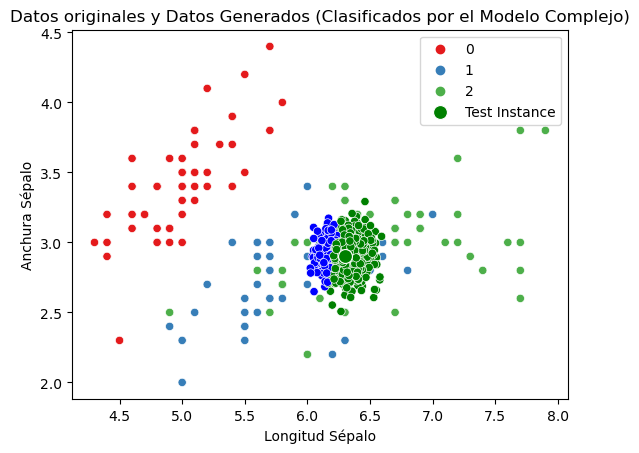

In [36]:
# Clasificar los datos perturbados con el modelo complejo
complex_predictions = complex_model.predict(perturbed_data)

# Definir una paleta de colores personalizada para las clases
custom_palette = {1: 'blue', 2: 'green'}

# Gráfica de los puntos generados por bootstrap clasificados por el modelo complejo
sns.scatterplot(x='Longitud Sépalo', y='Anchura Sépalo', hue='Target', data=data_df, palette="Set1")
sns.scatterplot(x=perturbed_data[:, 0], y=perturbed_data[:, 1], hue=complex_predictions, palette=custom_palette, legend=False)
sns.scatterplot(x=[test_instance[0]], y=[test_instance[1]], marker='o', color='green', s=100, label='Test Instance')
plt.xlabel('Longitud Sépalo')
plt.ylabel('Anchura Sépalo')
plt.title('Datos originales y Datos Generados (Clasificados por el Modelo Complejo)')
plt.legend()
plt.show()


## Ajuste modelo interpretable en el entorno

Esta parte no es necesaria para esta instancia en particular, pero podría serla con otras instancias.

Como queremos aproximar localmente usando regresión logística, necesitamos un problema de clasificación con solo dos posibles salidas, no tres como hay en el ejemplo. Para esto simplemente tomamos como posibles salidas si la clase del punto es la misma que la clase de la instancia en la que nos estamos fijando.

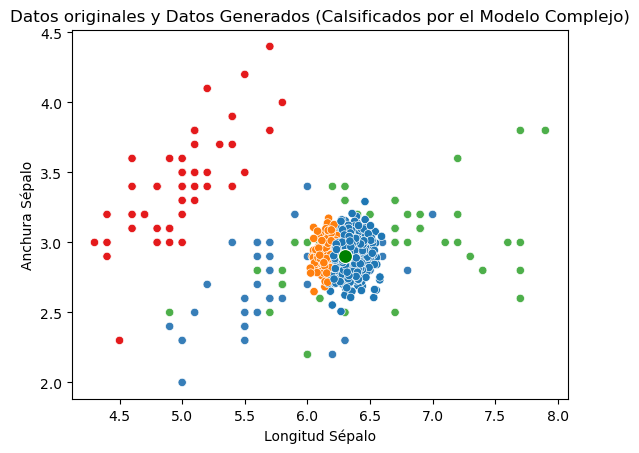

In [39]:
# Crear una lista de colores: azul para la clase 1 y amarillo para las demás clases
colors = ['green' if pred == 2 else 'yellow' for pred in complex_predictions]

# Gráfica de los puntos generados por bootstrap clasificados por el modelo complejo con etiquetas de color
sns.scatterplot(x='Longitud Sépalo', y='Anchura Sépalo', hue='Target', data=data_df, palette="Set1")
sns.scatterplot(x=perturbed_data[:, 0], y=perturbed_data[:, 1], hue=colors, legend=False)
sns.scatterplot(x=[test_instance[0]], y=[test_instance[1]], marker='o', color='green', s=100, label='Test Instance')
plt.xlabel('Longitud Sépalo')
plt.ylabel('Anchura Sépalo')
plt.title('Datos originales y Datos Generados (Calsificados por el Modelo Complejo)')
plt.legend().set_visible(False)  # Ocultar la leyenda de las representaciones de bootstrap
plt.show()

Una vez hecho esto vamos a buscar, en el rectángulo centrado en la instancia que estamos estudiando, el modelo de regresión logística que mejor se aproxima localmente.

In [40]:
# Crear etiquetas para el nuevo conjunto de datos
labels = [1 if pred == complex_model.predict([test_instance])[0] else 0 for pred in complex_predictions]

# Crear una lista de colores: azul para la clase 1 y amarillo para la clase 0
colors = ['green' if label == 1 else 'yellow' for label in labels]

# Entrenar un modelo de regresión logística en torno a la instancia seleccionada
simple_model = LogisticRegression()
simple_model.fit(perturbed_data, labels)

# Gráfica de la regresión logística local con etiquetas de color
xx, yy = np.meshgrid(np.linspace(perturbed_data[:, 0].min(), perturbed_data[:, 0].max(), 50),
                     np.linspace(perturbed_data[:, 1].min(), perturbed_data[:, 1].max(), 50))
Z = simple_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

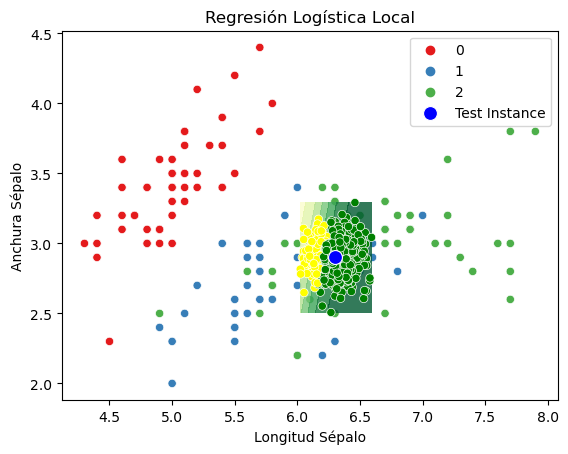

In [43]:
sns.scatterplot(x='Longitud Sépalo', y='Anchura Sépalo', hue='Target', data=data_df, palette="Set1")
plt.contourf(xx, yy, Z, cmap=plt.cm.YlGn, alpha=0.8)
sns.scatterplot(x=perturbed_data[:, 0], y=perturbed_data[:, 1], hue=colors, palette=["green", "yellow"], legend=False)
sns.scatterplot(x=[test_instance[0]], y=[test_instance[1]], marker='o', color='blue', s=100, label='Test Instance')
plt.xlabel('Longitud Sépalo')
plt.ylabel('Anchura Sépalo')
plt.title('Regresión Logística Local')
plt.legend()
plt.show()

## Interpretación modelo interpretable 

Aumentamos para ver mejor que está pasando en la región.

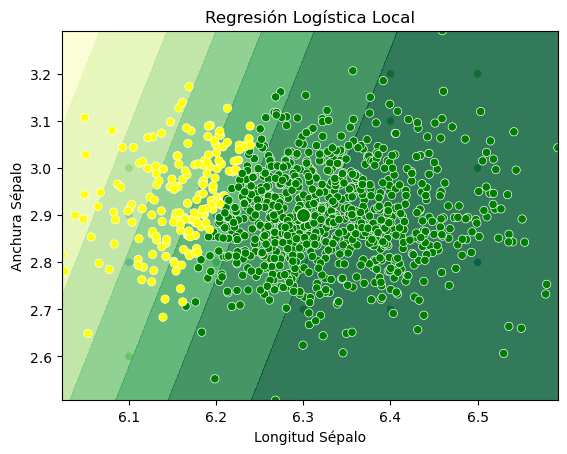

In [44]:
# Limitar los ejes x e y para mostrar solo la región de interés
plt.xlim([perturbed_data[:, 0].min(), perturbed_data[:, 0].max()])
plt.ylim([perturbed_data[:, 1].min(), perturbed_data[:, 1].max()])

sns.scatterplot(x='Longitud Sépalo', y='Anchura Sépalo', hue='Target', data=data_df, palette="Set1")
plt.contourf(xx, yy, Z, cmap=plt.cm.YlGn, alpha=0.8)
sns.scatterplot(x=perturbed_data[:, 0], y=perturbed_data[:, 1], hue=colors, palette=["green", "yellow"], legend=False)
sns.scatterplot(x=[test_instance[0]], y=[test_instance[1]], marker='o', color='green', s=100, label='Test Instance')
plt.xlabel('Longitud Sépalo')
plt.ylabel('Anchura Sépalo')
plt.title('Regresión Logística Local')
plt.legend().remove()
plt.show()

Ahora resulta muy fácil interpretar que cerca de la instancia que estamos estudiando, el modelo está clasificando de manera parecida a una regresión logística (separación por una recta) que podriamos calcular e interpretar fácilmente.

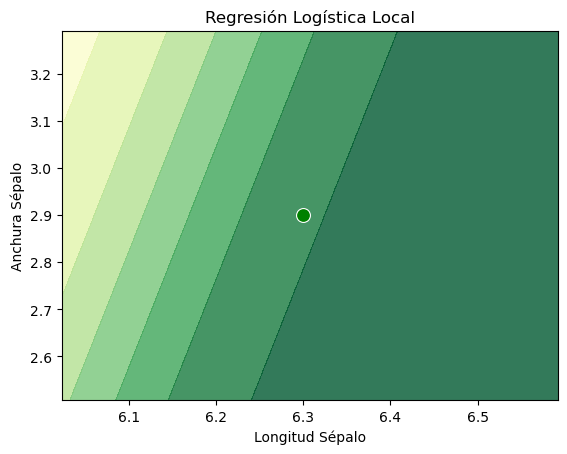

In [45]:
# Limitar los ejes x e y para mostrar solo la región de interés
plt.xlim([perturbed_data[:, 0].min(), perturbed_data[:, 0].max()])
plt.ylim([perturbed_data[:, 1].min(), perturbed_data[:, 1].max()])

plt.contourf(xx, yy, Z, cmap=plt.cm.YlGn, alpha=0.8)
sns.scatterplot(x=[test_instance[0]], y=[test_instance[1]], marker='o', color='green', s=100, label='Test Instance')
plt.xlabel('Longitud Sépalo')
plt.ylabel('Anchura Sépalo')
plt.title('Regresión Logística Local')
plt.legend().remove()
plt.show()

Específicamente la regresión logística viene dado por lo siguiente.

In [46]:
# Coeficientes y término independiente de la regresión logística local
coefficients = simple_model.coef_
intercept = simple_model.intercept_

print("Coeficientes:", coefficients)
print("Término independiente:", intercept)

# Crear la cadena de la fórmula
formula_string = "P(Y=1) = 1 / (1 + e^(-(%.4f + %.4f * X1 + %.4f * X2)))" % (intercept, coefficients[0][0], coefficients[0][1])

# Mostrar la fórmula
print(formula_string)


Coeficientes: [[11.52383851 -2.46586067]]
Término independiente: [-63.53273163]
P(Y=1) = 1 / (1 + e^(-(-63.5327 + 11.5238 * X1 + -2.4659 * X2)))


## Comprobación

Para este ejemplo, podemos mostrar la frontera de decisión que nos da el modelo complejo (red neuronal en este caso) y comprobar que efectivamente se asemeja a la frontera real.

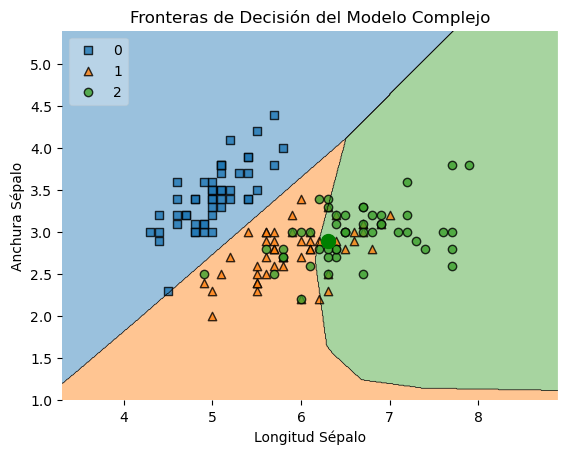

In [51]:
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X, y, clf=complex_model, legend=2)
plt.scatter(instance[0], instance[1], color='green', marker='o', s=100, label='Test Instance')
plt.xlabel('Longitud Sépalo')
plt.ylabel('Anchura Sépalo')
plt.title('Fronteras de Decisión del Modelo Complejo')
plt.show()

Vemos que LIME nos ha mostrado increíblemente bien la frontera de decisión en el entorno de la instancia, permitiendonos entender fácilmente la decisión del modelo cerca de este punto.